# Fake News Classification 

## Preprocessing

In [23]:
#%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import cross_validate
#getnews and datascience are custom python modules to avoid cluttering the notebook with source code
import getnews as news
import datascience as data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from nltk.corpus import stopwords
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_names = ['title','text','authors','num_images','domain','url']

dir_pol_real = '/Users/geetikasharma/Desktop/CSI5155_Final_Project/FakeNewsNet/code/fakenewsnet_dataset/politifact/real/'
dir_pol_fake = '/Users/geetikasharma/Desktop/CSI5155_Final_Project/FakeNewsNet/code/fakenewsnet_dataset/politifact/real/'
dir_gos_real = '/Users/geetikasharma/Desktop/CSI5155_Final_Project/FakeNewsNet/code/fakenewsnet_dataset/gossipcop/real/'
dir_gos_fake = '/Users/geetikasharma/Desktop/CSI5155_Final_Project/FakeNewsNet/code/fakenewsnet_dataset/gossipcop/fake/'
directory_list = [dir_pol_real,dir_pol_fake,dir_gos_real,dir_gos_fake]

In [24]:
def print_statistics(model_name, y_pred, y_true):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    print("\nThe accuracy for the model " + model_name + " is {0:.2%}".format(accuracy))
    print("The minority class recall for the model " + model_name + " is {0:.2%}".format(recall))
    print("The minority class f1 score for the model " + model_name + " is {0:.2%}".format(f1))
    print("The minority class precision for the model " + model_name + " is {0:.2%}".format(precision))
    print("The confusion matrix is given by: ")
    print(confusion_matrix(y_true, y_pred))
    return accuracy

# Compute and print the results from cross validation
def print_cross_validation(model, model_name, data, target):
    scoring = {'accuracy': 'accuracy',
               'recall': 'recall',
               'precision': 'precision',
               'roc_auc': 'roc_auc'}
    scores = cross_validate(model, data, target, cv=10, scoring=scoring)
    print("\nPrinting the results per fold for the " + model_name + " model")
    for i in range(0, 10):
        print("\nFold " + str(i + 1) + ": Accuracy " + " {0:.2%}".format(scores['test_accuracy'][i]))
        print("Fold " + str(i + 1) + ": Recall " + " {0:.2%}".format(scores['test_recall'][i]))
        print("Fold " + str(i + 1) + ": Precision " + " {0:.2%}".format(scores['test_precision'][i]))
        print("Fold " + str(i + 1) + ": ROC area " + " {0:.2%}".format(scores['test_roc_auc'][i]))
    return scores

## Get Data

In [25]:
df_pol_real = news.getnews(dir_pol_real)
df_pol_real.head()
df_pol_real = df_pol_real[df_pol_real.authors != '[]']
df_pol_real = df_pol_real[df_pol_real.num_images != '0']
df_pol_real.head()

,title,text,authors,num_images,domain,url,keywords,canonical_link,publish_date,summary,movies,source
0,Local News Headlines Hawaii,If you want to do business with Miller Industr...,['Rob Perez Rperez Staradvertiser.Com On Decem...,20,starbulletin,http://www.starbulletin.com/news/bulletin/9467...,0,36,NaN,,[],http://www.starbulletin.com
3,“Dictionary” on President Obama’s Health Care ...,WASHINGTON – The Republican National Committee...,"['Written On September', 'Republican National ...",32,archive,https://web.archive.org/web/20091003005639/htt...,0,86,NaN,,[http://www.youtube.com/v/o8UqQMa7q9Y&hl=en&fs...,https://web.archive.org
4,Rule by Rentiers,"Of course, that’s not the way what I call the ...",['Paul Krugman'],4,nytimes,http://www.nytimes.com/2011/06/10/opinion/10kr...,0,57,1.307678e+09,,[],http://www.nytimes.com
5,TSA: Frequently Asked Questions,Frequently Asked Questions\n\nAdvanced Imaging...,"['Transportation Security Administration', 'Ts...",6,archive,https://web.archive.org/web/20100716185746/htt...,0,0,NaN,,[],https://web.archive.org
17,H.R.1025 - 103rd Congress (1993-1994): Brady H...,There are 2 summaries for H.R.1025. Conference...,"['Schumer', 'Charles E.']",5,loc,http://thomas.loc.gov/cgi-bin/bdquery/z?d103:H...,0,61,NaN,,[],http://thomas.loc.gov


In [26]:
df_pol_real.shape

(78, 12)

In [27]:
df_pol_fake = news.getnews(dir_pol_fake)
df_pol_fake = df_pol_fake[df_pol_fake.authors != '[]']
df_pol_real = df_pol_fake[df_pol_fake.num_images != '0']
df_pol_fake.head()

,title,text,authors,num_images,domain,url,keywords,canonical_link,publish_date,summary,movies,source
0,Local News Headlines Hawaii,If you want to do business with Miller Industr...,['Rob Perez Rperez Staradvertiser.Com On Decem...,20,starbulletin,http://www.starbulletin.com/news/bulletin/9467...,0,36,NaN,,[],http://www.starbulletin.com
3,“Dictionary” on President Obama’s Health Care ...,WASHINGTON – The Republican National Committee...,"['Written On September', 'Republican National ...",32,archive,https://web.archive.org/web/20091003005639/htt...,0,86,NaN,,[http://www.youtube.com/v/o8UqQMa7q9Y&hl=en&fs...,https://web.archive.org
4,Rule by Rentiers,"Of course, that’s not the way what I call the ...",['Paul Krugman'],4,nytimes,http://www.nytimes.com/2011/06/10/opinion/10kr...,0,57,1.307678e+09,,[],http://www.nytimes.com
5,TSA: Frequently Asked Questions,Frequently Asked Questions\n\nAdvanced Imaging...,"['Transportation Security Administration', 'Ts...",6,archive,https://web.archive.org/web/20100716185746/htt...,0,0,NaN,,[],https://web.archive.org
17,H.R.1025 - 103rd Congress (1993-1994): Brady H...,There are 2 summaries for H.R.1025. Conference...,"['Schumer', 'Charles E.']",5,loc,http://thomas.loc.gov/cgi-bin/bdquery/z?d103:H...,0,61,NaN,,[],http://thomas.loc.gov


In [28]:
df_pol_fake.shape

(78, 12)

In [29]:
df_gos_real = news.getnews(dir_gos_real)
df_gos_real = df_gos_real[df_gos_real.authors != '[]']
df_gos_real = df_gos_real[df_gos_real.num_images != '0']
df_gos_real.head()

,title,text,authors,num_images,domain,url,keywords,canonical_link,publish_date,summary,movies,source
1,Kylie Jenner refusing to discuss Tyga on Life ...,Kylie Jenner reportedly doesn't want to talk a...,['Ross Mcdonagh For Dailymail.Com'],431,dailymail,https://www.dailymail.co.uk/tvshowbiz/article-...,0,109,1.499290e+09,,[],https://www.dailymail.co.uk
3,I Tried Kim Kardashian's Butt Workout & Am For...,"From there, you transition to the leg press ma...","['Karina Hoshikawa', 'Cory Stieg', 'Elizabeth ...",7,refinery29,https://www.refinery29.com/en-us/2018/03/19192...,0,92,1.521432e+09,,[],https://www.refinery29.com
4,Celine Dion donates concert proceeds to Vegas ...,(CNN) An emotional Celine Dion returned to the...,['Sandra Gonzalez'],5,cnn,https://www.cnn.com/2017/10/04/entertainment/c...,0,90,1.507090e+09,,[],https://www.cnn.com
5,Handmaid's Tale Renewed for Season 3,"I’m sorry, Aunt Lydia, but The Handmaid’s Tale...",['Michael Ausiello'],19,tvline,https://tvline.com/2018/05/02/the-handmaids-ta...,0,71,1.525234e+09,,[],https://tvline.com
6,A Complete Timeline of Selena Gomez and Justin...,Photography via Getty\n\nHave We Reached the E...,['Date July'],41,fashionmagazine,https://fashionmagazine.com/culture/selena-gom...,0,76,1.531043e+09,,[],https://fashionmagazine.com


In [30]:
df_gos_real.shape

(4032, 12)

In [31]:
df_gos_fake = news.getnews(dir_gos_fake)
df_gos_fake = df_gos_fake[df_gos_fake.authors != '[]']
df_gos_fake = df_gos_fake[df_gos_fake.num_images != '0']
df_gos_fake.head()

,title,text,authors,num_images,domain,url,keywords,canonical_link,publish_date,summary,movies,source
0,Did Miley Cyrus and Liam Hemsworth secretly ge...,Congratulations might be in order for Miley Cy...,['Caitlyn Hitt'],462,dailymail,www.dailymail.co.uk/tvshowbiz/article-5874213/...,0,106,1.529680e+09,,[],http://www.dailymail.co.uk
1,Paris Jackson & Cara Delevingne Enjoy Night Ou...,Paris Jackson and Cara Delevingne were spotted...,"['Courteney Larocca', 'Weekend Editor']",17,hollywoodlife,hollywoodlife.com/2018/05/05/paris-jackson-car...,0,109,1.525493e+09,,[],http://hollywoodlife.com
2,Celebrities Join Tax March in Protest of Donal...,Thousands are taking the streets to protest Pr...,"['Variety Staff', 'Follow Us On Twitter', ""Var...",29,variety,variety.com/2017/biz/news/tax-march-donald-tru...,0,76,1.492292e+09,,[],http://variety.com
3,Cindy Crawford's daughter Kaia Gerber wears a ...,We'd venture to say that Cindy Crawford's daug...,"['Carly Stern For Dailymail.Com', 'Jj Nattrass...",403,dailymail,www.dailymail.co.uk/femail/article-3499192/Do-...,0,171,1.458333e+09,,[],http://www.dailymail.co.uk
4,Oscar Nominations 2018: The Complete List,Follow Us on Twitter\n\nOscar nominations for ...,"['Variety Staff', 'Follow Us On Twitter', ""Var...",28,variety,variety.com/2018/film/news/list-2018-oscar-nom...,0,74,1.516714e+09,,[],http://variety.com


In [32]:
df_gos_fake.shape

(3642, 12)

## Scraped Dataset labeling and concatenation to get the final dataset

In [68]:
#remove rows that have no text in the text column
df_pol_real = news.cleandf(df=df_pol_real,col='text',exclude='')
df_pol_fake = news.cleandf(df=df_pol_fake,col='text',exclude='')
df_gos_real = news.cleandf(df=df_gos_real,col='text',exclude='')
df_gos_fake = news.cleandf(df=df_gos_fake,col='text',exclude='')

df_list = [df_pol_real,df_pol_fake,df_gos_real,df_gos_fake]

#'class' based on Real=1 or Fake=0
df_pol_real['class'] = 1
df_pol_fake['class'] = 0
df_gos_real['class'] = 1
df_gos_fake['class'] = 0

#combine df's into one
df = pd.concat(df_list).reset_index(drop=True)
df.to_csv(r'/Users/geetikasharma/Desktop/CSI5155_Final_Project/processed_dataset.csv', index = None, header=True)
tot_articles = df.shape[0]
df.shape

(7815, 13)

In [69]:
df.head(100)

,title,text,authors,num_images,domain,url,keywords,canonical_link,publish_date,summary,movies,source,class
0,Local News Headlines Hawaii,If you want to do business with Miller Industr...,['Rob Perez Rperez Staradvertiser.Com On Decem...,20,starbulletin,http://www.starbulletin.com/news/bulletin/9467...,0,36,NaN,,[],http://www.starbulletin.com,1
1,“Dictionary” on President Obama’s Health Care ...,WASHINGTON – The Republican National Committee...,"['Written On September', 'Republican National ...",32,archive,https://web.archive.org/web/20091003005639/htt...,0,86,NaN,,[http://www.youtube.com/v/o8UqQMa7q9Y&hl=en&fs...,https://web.archive.org,1
2,Rule by Rentiers,"Of course, that’s not the way what I call the ...",['Paul Krugman'],4,nytimes,http://www.nytimes.com/2011/06/10/opinion/10kr...,0,57,1.307678e+09,,[],http://www.nytimes.com,1
3,TSA: Frequently Asked Questions,Frequently Asked Questions\n\nAdvanced Imaging...,"['Transportation Security Administration', 'Ts...",6,archive,https://web.archive.org/web/20100716185746/htt...,0,0,NaN,,[],https://web.archive.org,1
4,H.R.1025 - 103rd Congress (1993-1994): Brady H...,There are 2 summaries for H.R.1025. Conference...,"['Schumer', 'Charles E.']",5,loc,http://thomas.loc.gov/cgi-bin/bdquery/z?d103:H...,0,61,NaN,,[],http://thomas.loc.gov,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Sen. Sanders warns of ‘frightening trend’ towa...,The defeat of the DISCLOSE Act in the Senate i...,"['Eric W. Dolan', 'Sarah K. Burris']",29,rawstory,http://www.rawstory.com/rs/2012/07/17/sen-sand...,0,90,1.342498e+09,,[https://www.youtube-nocookie.com/embed/Z_fpAr...,http://www.rawstory.com,0
96,RACE FOR CITY HALL: The Republican Candidate; ...,"The public had him pegged all wrong, he compla...","['Barry Bearak', 'Ian Fisher']",1,nytimes,http://query.nytimes.com/gst/fullpage.html?res...,0,124,NaN,,[],http://query.nytimes.com,0
97,H1N1 vaccinations to be offered to Guantanamo ...,Washington (CNN) -- The Pentagon will offer th...,"['Mike Mount', 'Cnn Senior Pentagon Producer']",8,cnn,http://www.cnn.com/2009/US/10/30/guantanamo.h1...,0,0,NaN,,[],http://www.cnn.com,0
98,VIDEO: Special Preview Of Jersey Shore In Miami!,Click to share on Facebook (Opens in new windo...,"['Radar Staff', 'June']",20,radaronline,http://www.radaronline.com/exclusives/2010/06/...,0,107,1.275907e+09,,[],http://www.radaronline.com,0


In [72]:
df.astype('object').describe(include='all').loc['unique', :]

title             7291
text              7183
authors           3200
num_images         197
domain             599
url               7335
keywords             1
canonical_link     213
publish_date      4151
summary              1
movies             476
source             857
class                2
Name: unique, dtype: object

# Upon careful observation of the dataset, the only meaningful features that have values and can be useful are : title, text, authors , num_images,  domain, and url
We therefore, drop the other coloumns from the dataframe!

In [73]:
df = df.drop(columns=['source', 'summary','publish_date','canonical_link','keywords','movies'])
print(df.shape)

(7815, 7)


In [74]:
df.head()

,title,text,authors,num_images,domain,url,class
0,Local News Headlines Hawaii,If you want to do business with Miller Industr...,['Rob Perez Rperez Staradvertiser.Com On Decem...,20,starbulletin,http://www.starbulletin.com/news/bulletin/9467...,1
1,“Dictionary” on President Obama’s Health Care ...,WASHINGTON – The Republican National Committee...,"['Written On September', 'Republican National ...",32,archive,https://web.archive.org/web/20091003005639/htt...,1
2,Rule by Rentiers,"Of course, that’s not the way what I call the ...",['Paul Krugman'],4,nytimes,http://www.nytimes.com/2011/06/10/opinion/10kr...,1
3,TSA: Frequently Asked Questions,Frequently Asked Questions\n\nAdvanced Imaging...,"['Transportation Security Administration', 'Ts...",6,archive,https://web.archive.org/web/20100716185746/htt...,1
4,H.R.1025 - 103rd Congress (1993-1994): Brady H...,There are 2 summaries for H.R.1025. Conference...,"['Schumer', 'Charles E.']",5,loc,http://thomas.loc.gov/cgi-bin/bdquery/z?d103:H...,1


# Lets identify if the dataset is skewed!

In [75]:
df['class'].value_counts() / df.shape[0]*100

1    52.488804
0    47.511196
Name: class, dtype: float64

## Exploratory Data Analysis

### Word Counts

Find the top 10 words by dataset

In [78]:
words = []
for item in df_list:
    words.append(list(data.cleanwordcounts(item.text).word.head(10)))

In [79]:
df_words = pd.DataFrame(words).T
df_words.columns = ['Politifact-Real','Politifact-Fake','Gossipcop-Real','Gossipcop-Fake']
df_words

,Politifact-Real,Politifact-Fake,Gossipcop-Real,Gossipcop-Fake
0,think,think,said,said
1,going,going,like,time
2,people,people,one,new
3,amanpour,amanpour,new,one
4,well,well,time,like
5,said,said,show,source
6,know,know,year,year
7,tapper,tapper,also,also
8,president,president,people,told
9,one,one,first,family


### Domains

In [80]:
domains = pd.DataFrame(df['domain'].value_counts())
domains.columns = ['count']
domains.head(15)

,count
people,755
hollywoodlife,480
dailymail,467
usmagazine,322
etonline,272
radaronline,184
hollywoodreporter,141
variety,138
newidea,137
inquisitr,137


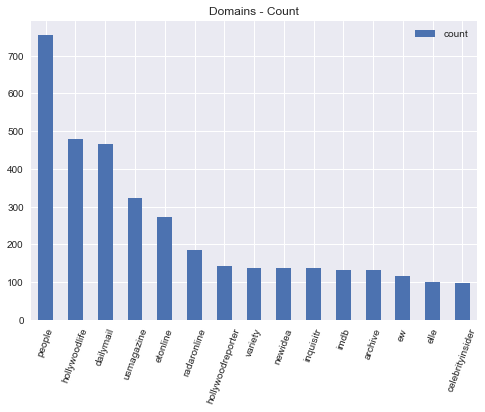

In [82]:
plt.style.use('seaborn')
domains.head(15).plot(kind='bar')
plt.xticks(rotation=70)
plt.title('Domains - Count')
plt.savefig('top_15_domains',bbox_inches="tight")

In [83]:
#common domains between real and fake news
polset = set(df_pol_real.domain.unique()).union(set(df_pol_fake.domain.unique()))
gosset = set(df_gos_real.domain.unique()).union(set(df_gos_fake.domain.unique()))
intersect = polset.intersection(gosset)
print(intersect)

{'cnn', 'guardian', 'washingtonpost', 'go', 'politico', 'archive', 'radaronline', 'huffingtonpost', 'cbsnews', 'nytimes', 'reuters'}


### Number of Images

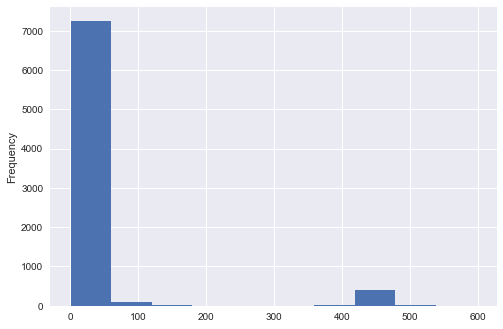

In [84]:
df.num_images.plot(kind='hist')
plt.savefig('num_images')

In [85]:
df['num_images'].describe()

count    7815.000000
mean       37.954319
std       101.464142
min         1.000000
25%         5.000000
50%        10.000000
75%        19.000000
max       598.000000
Name: num_images, dtype: float64

In [86]:
image_by_class = pd.pivot_table(df,index='class',aggfunc={'num_images':['mean','std']})
print(image_by_class)

      num_images            
            mean         std
class                       
0      33.343119   90.946808
1      42.128230  109.965915


### Domain Analysis

In [92]:
#counts of true vs fake articles by domain
#and the truthfulness of the site by %true column
df_sum = pd.pivot_table(df,index='domain',columns='class',fill_value=0,aggfunc={'domain':'count'})
df_sum['%true'] = df_sum.apply(lambda row: row[1]/(row[0]+row[1]),axis=1)
df_sum[(df_sum['%true']!=1)&(df_sum['%true']!=0)].sort_values(by='%true',ascending = False)

domain         %true
class                   0   1          
domain                                 
medium                  2  62  0.968750
tvline                  1  24  0.960000
scoopnest               1  23  0.958333
upi                     2  24  0.923077
stylecaster             1  12  0.923077
...                   ...  ..       ...
ibtimes                39   3  0.071429
thehollywoodgossip     41   3  0.068182
hollywoodlife         456  24  0.050000
radaronline           175   9  0.048913
lifeandstylemag        51   1  0.019231

[206 rows x 3 columns]

As evident medium, tvline, scoopnest are generally most trustworthy domains while hollywoodlife, radaronline, lifestylemag are few of the worst performing domains!!

# Machine Learning

As evident, the dataset mostly contains textual features and of them we will be using the 'text' feature for our model. The reason is two-fold : (a) developing a content-aware model requires us to focus on the text of the body of the news article as the main feature , and (b) the 'text' feature using NLP techniques is the richest feature to build an efficient and accurate model.

# Feature Tranformation : TfidfVectorizer

In [101]:
stop_words = stopwords.words('english')
#make vectorizer
vectorizer = TfidfVectorizer(analyzer='word',token_pattern=r'\w+', stop_words=stop_words, min_df=2)
#fit text
vectorizer.fit(df.text)
#transform to sparse array
fitted = vectorizer.transform(df.text)
print(fitted.shape)

(7815, 38549)


In [103]:
print(vectorizer.vocabulary_)

{'want': 37325, 'business': 5650, 'miller': 22436, 'industries': 17700, 'need': 23576, 'pick': 25986, 'phone': 25934, 'actual': 1389, 'conversation': 8257, 'human': 17007, 'better': 4238, 'stop': 33098, 'shop': 31242, 'kalihi': 19099, 'street': 33215, 'face': 12812, 'one': 24494, 'beings': 4005, 'read': 27966, 'washington': 37390, 'republican': 28809, 'national': 23475, 'committee': 7622, 'announced': 2395, 'new': 23694, 'web': 37501, 'video': 36939, 'today': 35025, 'president': 26872, 'obama': 24198, 'health': 16171, 'care': 6079, 'taxes': 34273, 'months': 22905, 'tried': 35520, 'convince': 8276, 'american': 2168, 'people': 25666, 'government': 15176, 'run': 29825, 'experiment': 12639, 'gain': 14390, 'pain': 25048, 'buying': 5695, 'fact': 12839, 'plan': 26195, 'contains': 8141, 'huge': 16991, 'harm': 15975, 'economy': 11420, 'cost': 8458, 'jobs': 18797, 'democrats': 9734, 'paying': 25495, 'dangerous': 9219, 'higher': 16460, 'small': 31850, 'owners': 24971, 'charitable': 6602, 'giving'

In [104]:
print(vectorizer.idf_)

[5.3004891  6.27504874 3.63242634 ... 8.86531591 8.86531591 8.57763383]


The conversion of the text column of the dataframe gives us a featureset of

# 0 Baseline Model : Multinomial Naive Bayes

In [109]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB

# Convert to dense numpy array
X = fitted.toarray()
#make response variables
y = df['class'].values
#split testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
#alpha values for manual grid search, slow evaluation
alpha_list = np.arange(1.5,1.9,0.1)
clf_scores = []
classifiers = []
for alpha in alpha_list:
    #instantiate naive bayes classifier
    clf_mnb = MultinomialNB(alpha=alpha)
    #fit data using vectorized words and compute cross validated score
    clf_mnb.fit(X_train,y_train)
    clf_score_mnb = np.mean(cross_val_score(clf_mnb,X_test,y_test,cv=5))
    #append score to list
    clf_scores.append(clf_score_mnb)
    classifiers.append(clf_mnb)
y_pred_mnb = clf_mnb.predict(X_test)
mnb_clf_cross_validation_scores = print_cross_validation(clf_mnb, "Multinomial Naive Bayes", X_train, y_train)


Printing the results per fold for the Multinomial Naive Bayes model

Fold 1: Accuracy  77.19%
Fold 1: Recall  79.69%
Fold 1: Precision  77.08%
Fold 1: ROC area  85.80%

Fold 2: Accuracy  79.52%
Fold 2: Recall  83.64%
Fold 2: Precision  78.32%
Fold 2: ROC area  87.23%

Fold 3: Accuracy  79.84%
Fold 3: Recall  79.32%
Fold 3: Precision  81.33%
Fold 3: ROC area  88.78%

Fold 4: Accuracy  77.28%
Fold 4: Recall  81.79%
Fold 4: Precision  76.15%
Fold 4: ROC area  85.31%

Fold 5: Accuracy  76.64%
Fold 5: Recall  77.16%
Fold 5: Precision  77.64%
Fold 5: ROC area  85.63%

Fold 6: Accuracy  80.48%
Fold 6: Recall  84.26%
Fold 6: Precision  79.36%
Fold 6: ROC area  87.76%

Fold 7: Accuracy  82.24%
Fold 7: Recall  83.95%
Fold 7: Precision  82.18%
Fold 7: ROC area  88.90%

Fold 8: Accuracy  80.16%
Fold 8: Recall  84.26%
Fold 8: Precision  78.90%
Fold 8: ROC area  86.49%

Fold 9: Accuracy  76.80%
Fold 9: Recall  79.01%
Fold 9: Precision  76.88%
Fold 9: ROC area  84.79%

Fold 10: Accuracy  80.00%
Fold

In [58]:
#plot confusion matrix for Multinomial Naive Bayes Classifier
#clf = classifiers[clf_scores.index(max(clf_scores))]

#data.plot_confusion_matrix(y_test,y_pred,[1,0],normalize=False)

In [107]:
#calculate model metrics
from sklearn.metrics import precision_recall_fscore_support, auc, roc_curve
bayes_metrics = precision_recall_fscore_support(y_test,y_pred_mnb,average='weighted')

print('Weighted Precision: {0:.2f}%'.format(bayes_metrics[0]*100))
print('Weighted Recall: {0:.2f}%'.format(bayes_metrics[1]*100))
print('Weighted F-Score: {0:.2f}%'.format(bayes_metrics[2]*100))

Weighted Precision: 79.77%
Weighted Recall: 79.78%
Weighted F-Score: 79.77%


# 1 Linear Model : Support Vector Machine

In [108]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
# Convert to dense numpy array
X = fitted.toarray()
#make response variables
y = df['class'].values
#split testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
#alpha values for manual grid search, slow evaluation
clf_svm = LinearSVC(random_state=0, tol=1e-5, loss = 'hinge')
#fit data using vectorized words and compute cross validated score
clf_svm.fit(X_train,y_train)
clf_score_svm = np.mean(cross_val_score(clf_svm,X_test,y_test,cv=5))
y_pred_svm = clf_svm.predict(X_test)
svm_clf_cross_validation_scores = print_cross_validation(clf_svm, "Support Vector Machine", X_train, y_train)


Printing the results per fold for the Support Vector Machine model

Fold 1: Accuracy  80.35%
Fold 1: Recall  87.61%
Fold 1: Precision  77.96%
Fold 1: ROC area  87.84%

Fold 2: Accuracy  82.11%
Fold 2: Recall  88.82%
Fold 2: Precision  79.67%
Fold 2: ROC area  89.43%

Fold 3: Accuracy  79.71%
Fold 3: Recall  83.38%
Fold 3: Precision  79.31%
Fold 3: ROC area  87.66%

Fold 4: Accuracy  79.07%
Fold 4: Recall  85.80%
Fold 4: Precision  77.17%
Fold 4: ROC area  87.15%

Fold 5: Accuracy  80.00%
Fold 5: Recall  84.89%
Fold 5: Precision  78.93%
Fold 5: ROC area  88.10%

Fold 6: Accuracy  81.28%
Fold 6: Recall  87.92%
Fold 6: Precision  79.08%
Fold 6: ROC area  88.25%

Fold 7: Accuracy  80.32%
Fold 7: Recall  83.38%
Fold 7: Precision  80.23%
Fold 7: ROC area  88.49%

Fold 8: Accuracy  80.64%
Fold 8: Recall  87.92%
Fold 8: Precision  78.23%
Fold 8: ROC area  88.24%

Fold 9: Accuracy  79.97%
Fold 9: Recall  87.27%
Fold 9: Precision  77.63%
Fold 9: ROC area  85.49%

Fold 10: Accuracy  81.57%
Fold 

# 2 Decision -Based Model : Decision Tree 

In [110]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
# Convert to dense numpy array
X = fitted.toarray()
#make response variables
y = df['class'].values
#split testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
#alpha values for manual grid search, slow evaluation
clf_DT = DecisionTreeClassifier(max_depth=8, criterion="gini", min_samples_split=2)
#fit data using vectorized words and compute cross validated score
clf_DT.fit(X_train,y_train)
clf_score_DT = np.mean(cross_val_score(clf_DT,X_test,y_test,cv=5))
y_pred_DT = clf_DT.predict(X_test)
dt_clf_cross_validation_scores = print_cross_validation(clf_DT, "Decision Tree", X_train, y_train)

r = export_text(clf_DT)
print(r)


Printing the results per fold for the Decision Tree model

Fold 1: Accuracy  75.08%
Fold 1: Recall  85.32%
Fold 1: Precision  72.09%
Fold 1: ROC area  75.38%

Fold 2: Accuracy  73.16%
Fold 2: Recall  82.57%
Fold 2: Precision  70.87%
Fold 2: ROC area  75.37%

Fold 3: Accuracy  76.84%
Fold 3: Recall  87.46%
Fold 3: Precision  73.33%
Fold 3: ROC area  77.58%

Fold 4: Accuracy  73.44%
Fold 4: Recall  81.96%
Fold 4: Precision  71.47%
Fold 4: ROC area  76.21%

Fold 5: Accuracy  75.36%
Fold 5: Recall  80.73%
Fold 5: Precision  74.37%
Fold 5: ROC area  75.58%

Fold 6: Accuracy  71.68%
Fold 6: Recall  87.16%
Fold 6: Precision  67.86%
Fold 6: ROC area  72.94%

Fold 7: Accuracy  72.80%
Fold 7: Recall  89.30%
Fold 7: Precision  68.38%
Fold 7: ROC area  74.13%

Fold 8: Accuracy  73.76%
Fold 8: Recall  85.32%
Fold 8: Precision  70.63%
Fold 8: ROC area  74.45%

Fold 9: Accuracy  74.40%
Fold 9: Recall  90.52%
Fold 9: Precision  69.65%
Fold 9: ROC area  77.28%

Fold 10: Accuracy  76.44%
Fold 10: Recal

In [115]:
file = open('Decision_Tree.txt', 'w')
file.write(r)
file.close()

# 3 Distance-Based Model : K-Nearest Neighbors

In [119]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
# Convert to dense numpy array
X = fitted.toarray()
#make response variables
y = df['class'].values
#split testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
#alpha values for manual grid search, slow evaluation

clf_knn = KNeighborsClassifier(n_neighbors=3)
#fit data using vectorized words and compute cross validated score
clf_knn.fit(X_train,y_train)
clf_score_knn = np.mean(cross_val_score(clf_knn,X_test,y_test,cv=5))
y_pred_knn = clf_knn.predict(X_test)
knn_clf_cross_validation_scores = print_cross_validation(clf_knn, "3-Nearest Neighbor", X_train, y_train)


Printing the results per fold for the 3-Nearest Neighbor model

Fold 1: Accuracy  76.20%
Fold 1: Recall  74.55%
Fold 1: Precision  79.10%
Fold 1: ROC area  82.98%

Fold 2: Accuracy  75.40%
Fold 2: Recall  72.12%
Fold 2: Precision  79.33%
Fold 2: ROC area  82.18%

Fold 3: Accuracy  76.32%
Fold 3: Recall  71.82%
Fold 3: Precision  81.16%
Fold 3: ROC area  81.23%

Fold 4: Accuracy  74.24%
Fold 4: Recall  74.55%
Fold 4: Precision  76.16%
Fold 4: ROC area  79.28%

Fold 5: Accuracy  71.52%
Fold 5: Recall  68.18%
Fold 5: Precision  75.50%
Fold 5: ROC area  78.79%

Fold 6: Accuracy  74.24%
Fold 6: Recall  72.12%
Fold 6: Precision  77.52%
Fold 6: ROC area  78.64%

Fold 7: Accuracy  73.60%
Fold 7: Recall  73.03%
Fold 7: Precision  76.03%
Fold 7: ROC area  78.07%

Fold 8: Accuracy  74.40%
Fold 8: Recall  70.61%
Fold 8: Precision  78.72%
Fold 8: ROC area  81.03%

Fold 9: Accuracy  76.00%
Fold 9: Recall  72.12%
Fold 9: Precision  80.41%
Fold 9: ROC area  81.25%

Fold 10: Accuracy  75.52%
Fold 10: 

# 4 Ensemble Model : Random Forest

In [116]:
from sklearn.ensemble import RandomForestClassifier
clf_rfc = RandomForestClassifier(n_estimators=10)
clf_rfc.fit(X_train,y_train)
clf_score_rfc = np.mean(cross_val_score(clf_rfc,X_test,y_test,cv=5))
y_pred_rfc = clf_rfc.predict(X_test)
rfc_clf_cross_validation_scores = print_cross_validation(clf_rfc, "Random Forest", X_train, y_train)


Printing the results per fold for the Random Forest model

Fold 1: Accuracy  72.73%
Fold 1: Recall  68.69%
Fold 1: Precision  76.87%
Fold 1: ROC area  81.63%

Fold 2: Accuracy  75.20%
Fold 2: Recall  72.26%
Fold 2: Precision  78.74%
Fold 2: ROC area  82.21%

Fold 3: Accuracy  73.76%
Fold 3: Recall  71.95%
Fold 3: Precision  76.62%
Fold 3: ROC area  80.66%

Fold 4: Accuracy  74.88%
Fold 4: Recall  77.44%
Fold 4: Precision  75.37%
Fold 4: ROC area  81.53%

Fold 5: Accuracy  73.12%
Fold 5: Recall  75.00%
Fold 5: Precision  74.10%
Fold 5: ROC area  79.47%

Fold 6: Accuracy  72.16%
Fold 6: Recall  73.78%
Fold 6: Precision  73.33%
Fold 6: ROC area  79.27%

Fold 7: Accuracy  71.36%
Fold 7: Recall  69.82%
Fold 7: Precision  74.11%
Fold 7: ROC area  78.18%

Fold 8: Accuracy  73.60%
Fold 8: Recall  73.48%
Fold 8: Precision  75.55%
Fold 8: ROC area  82.36%

Fold 9: Accuracy  72.00%
Fold 9: Recall  69.51%
Fold 9: Precision  75.25%
Fold 9: ROC area  80.75%

Fold 10: Accuracy  74.56%
Fold 10: Recal

# 5 Rule-Based Model : SkopeRule

In [117]:
from skrules import SkopeRules
clf_sr = SkopeRules(random_state=42, n_estimators=10)
clf_sr.fit(X_train, y_train)
y_sr_pred = clf_sr.predict(X_test)
sr_clf_cross_validation_scores = print_cross_validation(clf_sr, "SkopeRules", X_train, y_train)

print('The 4 most precise rules are the following:')
for rule in clf_sr.rules_[:4]:
    print(rule[0])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)



Printing the results per fold for the SkopeRules model

Fold 1: Accuracy  69.17%
Fold 1: Recall  94.23%
Fold 1: Precision  62.69%
Fold 1: ROC area  78.02%

Fold 2: Accuracy  68.21%
Fold 2: Recall  93.59%
Fold 2: Precision  62.00%
Fold 2: ROC area  76.64%

Fold 3: Accuracy  73.60%
Fold 3: Recall  95.68%
Fold 3: Precision  68.88%
Fold 3: ROC area  78.34%

Fold 4: Accuracy  72.80%
Fold 4: Recall  95.59%
Fold 4: Precision  67.71%
Fold 4: ROC area  75.74%

Fold 5: Accuracy  70.40%
Fold 5: Recall  94.75%
Fold 5: Precision  64.63%
Fold 5: ROC area  75.25%

Fold 6: Accuracy  71.52%
Fold 6: Recall  95.67%
Fold 6: Precision  65.33%
Fold 6: ROC area  74.54%

Fold 7: Accuracy  70.56%
Fold 7: Recall  97.12%
Fold 7: Precision  65.95%
Fold 7: ROC area  77.19%

Fold 8: Accuracy  71.04%
Fold 8: Recall  96.28%
Fold 8: Precision  64.79%
Fold 8: ROC area  75.22%

Fold 9: Accuracy  71.20%
Fold 9: Recall  89.39%
Fold 9: Precision  67.05%
Fold 9: ROC area  72.43%

Fold 10: Accuracy  71.84%
Fold 10: Recall  

In [118]:
file = open('Skope_Rule.txt', 'w')
for rule in clf_sr.rules_[:4]:
    file.write(rule[0])
file.close()

# Statistical Evaluation of the 5 Models

In [121]:
from scipy import stats
from termcolor import colored

# Compute the Paired t signed rank test for a subset of pairs
# of the models on the accuracy and recall per fold respectively
def paired_t_test(data1, data2, model1name, model2name):
    accuracy_t, accuracy_p_value = stats.ttest_ind(data1["test_accuracy"], data2["test_accuracy"])
    print("\nPrinting stats for models " + model1name + " and " + model2name)
    print("The T statistic for accuracy is given by " + str(accuracy_t))
    if accuracy_p_value < 0.05:
        print(colored("The accuracy of the models is significantly different",'red'))
    else:
        print("The accuracy of the models is not significantly different")

    
# Compute the pairwise t-test
paired_t_test(mnb_clf_cross_validation_scores, svm_clf_cross_validation_scores, "Multinomial Naive Bayes",
                           "Support Vector Machine")
paired_t_test(mnb_clf_cross_validation_scores, dt_clf_cross_validation_scores, "Multinomial Naive Bayes",
                           "Decision Tree")
paired_t_test(mnb_clf_cross_validation_scores, knn_clf_cross_validation_scores, "Multinomial Naive Bayes",
                           "3-NN")
paired_t_test(mnb_clf_cross_validation_scores, rfc_clf_cross_validation_scores, "Multinomial Naive Bayes",
                           "Random Forest")
paired_t_test(mnb_clf_cross_validation_scores, sr_clf_cross_validation_scores, "Multinomial Naive Bayes",
                           "Skope Rule")
paired_t_test(svm_clf_cross_validation_scores, dt_clf_cross_validation_scores, "Support Vector Machine",
                           "Decision Tree")
paired_t_test(svm_clf_cross_validation_scores, knn_clf_cross_validation_scores, "Support Vector Machine",
                           "3-NN")
paired_t_test(svm_clf_cross_validation_scores, rfc_clf_cross_validation_scores, "Support Vector Machine",
                           "Random Forest")
paired_t_test(svm_clf_cross_validation_scores, sr_clf_cross_validation_scores, "Support Vector Machine",
                           "Skope Rule")
paired_t_test(dt_clf_cross_validation_scores, knn_clf_cross_validation_scores, "Decision Tree",
                           "3-NN")
paired_t_test(dt_clf_cross_validation_scores, rfc_clf_cross_validation_scores, "Decision Tree",
                           "Random Forest")
paired_t_test(dt_clf_cross_validation_scores, sr_clf_cross_validation_scores, "Decision Tree",
                           "Skope Rule")
paired_t_test(knn_clf_cross_validation_scores, rfc_clf_cross_validation_scores, "3-NN",
                           "Random Forest")
paired_t_test(knn_clf_cross_validation_scores, sr_clf_cross_validation_scores, "3-NN",
                           "Skope Rule")
paired_t_test(rfc_clf_cross_validation_scores, sr_clf_cross_validation_scores, "Random Forest",
                           "Skope Rule")

# Take majority vote of all the models 
def compute_majority_vote(pred_array):
    predictions = []
    for i in range(0, len(pred_array[0])):
        votes_for_minority = 0
        votes_for_majority = 0
        for j in range(0, len(pred_array)):
            if pred_array[j][i] == 1:
                votes_for_minority = votes_for_minority + 1
            else:
                votes_for_majority = votes_for_majority + 1
        if votes_for_minority > votes_for_majority:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

model_array = [y_pred_svm, y_pred_DT, y_pred_knn, y_pred_rfc, y_sr_pred]
overall_pred = compute_majority_vote(model_array)
print_statistics("Overall Predictions", overall_pred, y_test)


Printing stats for models Multinomial Naive Bayes and Support Vector Machine
The T statistic for accuracy is given by -2.2239249704816952
The accuracy of the models is significantly different

Printing stats for models Multinomial Naive Bayes and Decision Tree
The T statistic for accuracy is given by 5.937795554075528
The accuracy of the models is significantly different

Printing stats for models Multinomial Naive Bayes and 3-NN
The T statistic for accuracy is given by 5.610050555383169
The accuracy of the models is significantly different

Printing stats for models Multinomial Naive Bayes and Random Forest
The T statistic for accuracy is given by 7.797150865482165
The accuracy of the models is significantly different

Printing stats for models Multinomial Naive Bayes and Skope Rule
The T statistic for accuracy is given by 10.17911709928993
The accuracy of the models is significantly different

Printing stats for models Support Vector Machine and Decision Tree
The T statistic for acc

0.5847728726807422

# ROC_curves

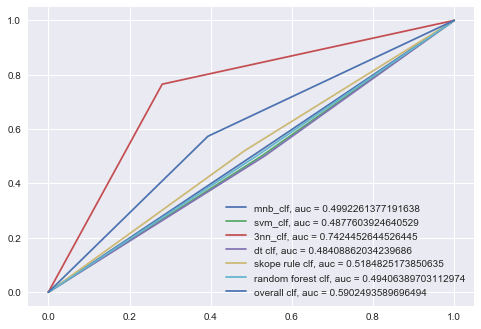

In [122]:
# Print the ROC Curves of each model
fig = plt.figure(0).clf()
model_array = [y_pred_svm, y_pred_DT, y_pred_knn, y_pred_rfc, y_sr_pred]

mnb_clf_auc = roc_auc_score(y_pred_mnb, y_test)
mnb_clf_fpr, mnb_clf_tpr, _ = roc_curve(y_pred_mnb, y_test, pos_label=1)
plt.plot(mnb_clf_fpr, mnb_clf_tpr, label="mnb_clf, auc = " + str(mnb_clf_auc))

svm_clf_auc = roc_auc_score(y_pred_svm, y_test)
svm_clf_fpr, svm_clf_tpr, _ = roc_curve(y_pred_svm, y_test, pos_label=1)
plt.plot(svm_clf_fpr, svm_clf_tpr, label="svm_clf, auc = " + str(svm_clf_auc))

knn_auc = roc_auc_score(y_pred_knn, y_test)
knn_fpr, knn_tpr, _ = roc_curve(y_pred_knn, y_test)
plt.plot(knn_fpr, knn_tpr, label="3nn_clf, auc = " + str(knn_auc))

dt_auc = roc_auc_score(y_pred_DT, y_test)
dt_fpr, dt_tpr, _ = roc_curve(y_pred_DT, y_test, pos_label=1)
plt.plot(dt_fpr, dt_tpr, label="dt clf, auc = " + str(dt_auc))

sr_clf_auc = roc_auc_score(y_sr_pred, y_test)
sr_clf_fpr, sr_clf_tpr, _ = roc_curve(y_sr_pred, y_test, pos_label=1)
plt.plot(sr_clf_fpr, sr_clf_tpr, label="skope rule clf, auc = " + str(sr_clf_auc))

rfc_auc = roc_auc_score(y_pred_rfc, y_test)
rfc_fpr, rfc_tpr, _ = roc_curve(y_pred_rfc, y_test, pos_label=1)
plt.plot(rfc_fpr, rfc_tpr, label="random forest clf, auc = " + str(rfc_auc))

overall_auc = roc_auc_score(overall_pred, y_test)
overall_fpr, overall_tpr, _ = roc_curve(overall_pred, y_test,  pos_label=1)
plt.plot(overall_fpr, overall_tpr, label="overall clf, auc = "+str(overall_auc))
plt.legend(loc=0)
plt.savefig('ROC_AUC_Curves',bbox_inches="tight")

# CONCLUSION